In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from cw2 import sorted_barplot

from scipy.stats import norm

data = sio.loadmat('tennis_data.mat')

W = data['W']
for i, player in enumerate(W):
    W[i] = player[0]
    
G = data['G'] - 1

# Number of players
M = W.shape[0]

# Number of Games
N = G.shape[0]

print('M =', M)
print('N =', N)

# -----------------------------------------

names = ['Novak-Djokovic', 'Rafael-Nadal', 'Roger-Federer', 'Andy-Murray']
ATP_top_players = []

for name in names:
    index = np.where(W == name)[0][0]
    ATP_top_players.append(index)

print(ATP_top_players)

M = 107
N = 1801
[15, 0, 4, 10]


In [2]:
G

array([[  0,   1],
       [  0,   2],
       [  0,   2],
       ...,
       [ 94,  95],
       [ 95, 104],
       [104, 106]], dtype=uint8)

# Rank players from predicted outcomes.

In [3]:
fontsize = 30

### e1) predict outcome from *empirical game outcome averages*

percentage of games won in all the games the player was in.

Disadvantage: Doesn't take into account **who** the player have defeated - if player A, with low skill, has mainly only played with others who have even lower skills than him (or her), (s)he will have a higher percentage of wins. However this will not mean that A should be ranked higher than player B who has significantly higher skill but has only played a few games in the most advanced league, and lost most of them because B's opponents were all world's champions.

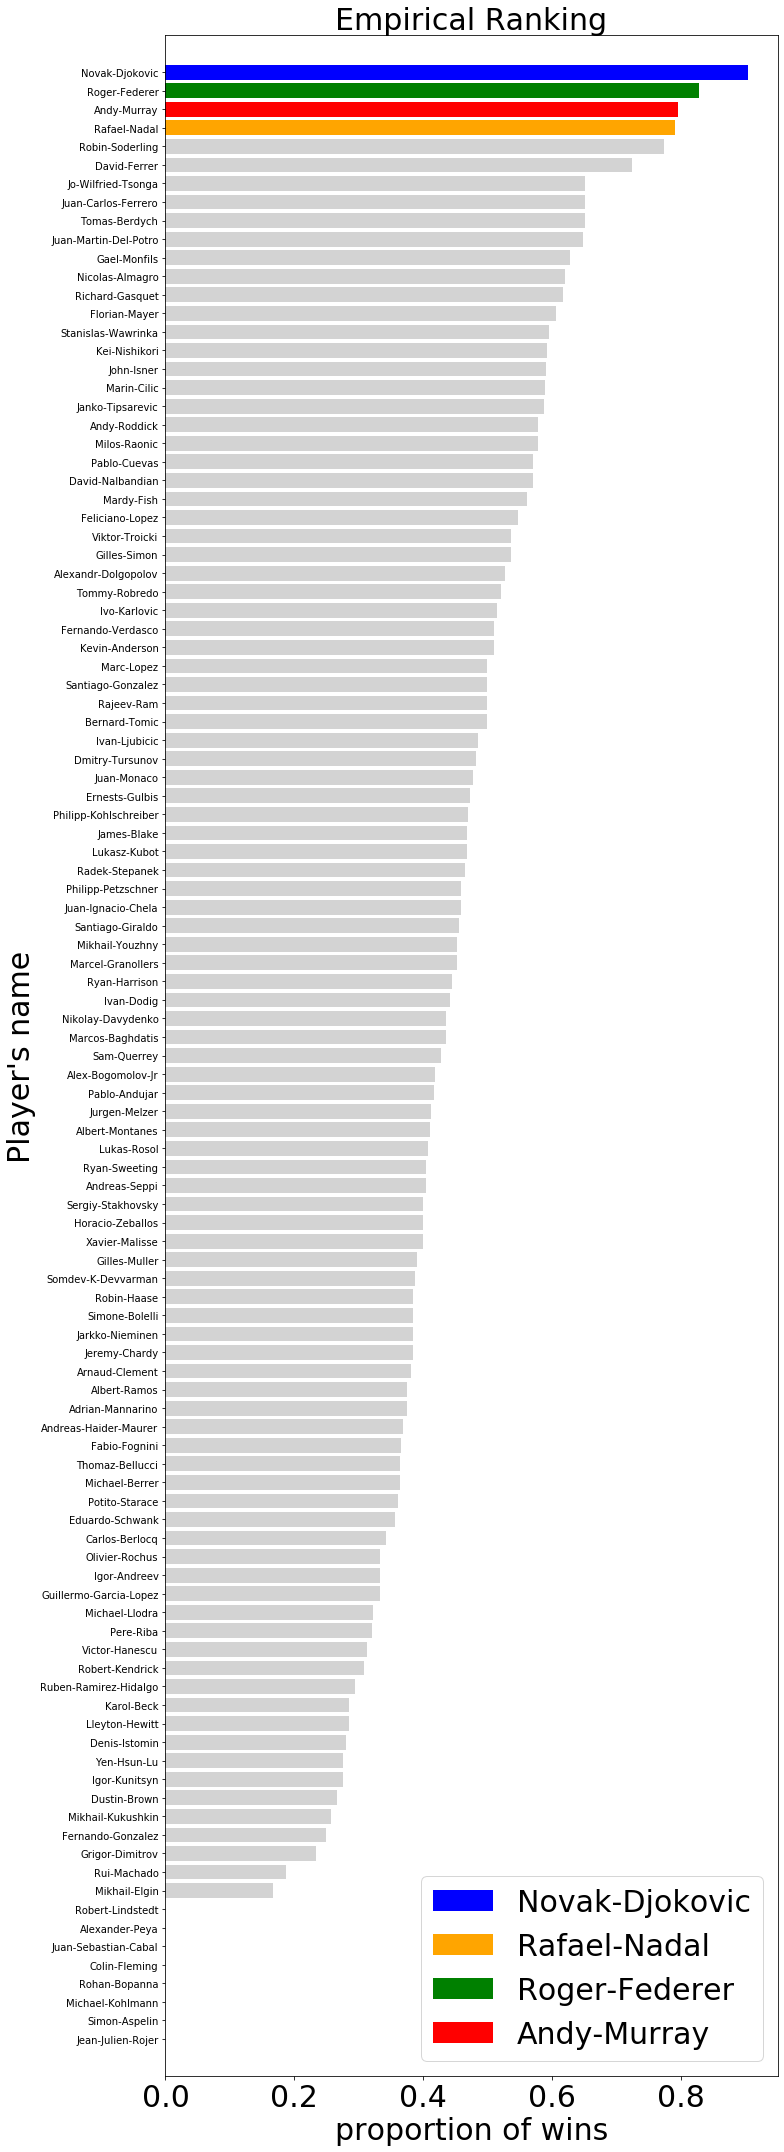

In [4]:
winning_players = G[:,0]
losing_players = G[:,1]

num_wins = np.zeros((M,1))
for g in range(N):
    p = winning_players[g]
    num_wins[p] += 1

num_games = num_wins.copy()
for g in range(N):
    p = losing_players[g]
    num_games[p] += 1
    
percent_wins = []
for p in range(M):
    percent_wins.append(float(num_wins[p] / num_games[p]))
    
percent_wins = np.array(percent_wins)
# print(percent_wins)
sorted_barplot(percent_wins, W, ATP_top_players, 'Empirical Ranking', 'lightgrey')
# plt.xlabel('percentage of wins in all the games of the player', fontsize=fontsize)
plt.xlabel('proportion of wins', fontsize=fontsize)
plt.ylabel("Player's name", fontsize=fontsize)
plt.xticks(fontsize=fontsize)

plt.tight_layout()
plt.savefig('e_result/e_empirical.jpg')
# plt.savefig('e_result/e_result_empirical.jpg')

In [5]:
empirical_worst_players = ['Robert-Lindstedt', 'Alexander-Peya', 'Juan-Sebastian-Cabal', 'Colin-Fleming', 'Rohan-Bopanna',\
                           'Michael-Kohlmann', 'Simon-Aspelin', 'Jean-Julien-Rojer']

### e2) predict outcome from *Gibbs samples*

Average probability of that player winning other players.

Although it was concluded that joint skill distribution is better than the marginal distribution in determining the probability of higher skill, marginal distributions are necessary to predict the game outcomes in our generative model.

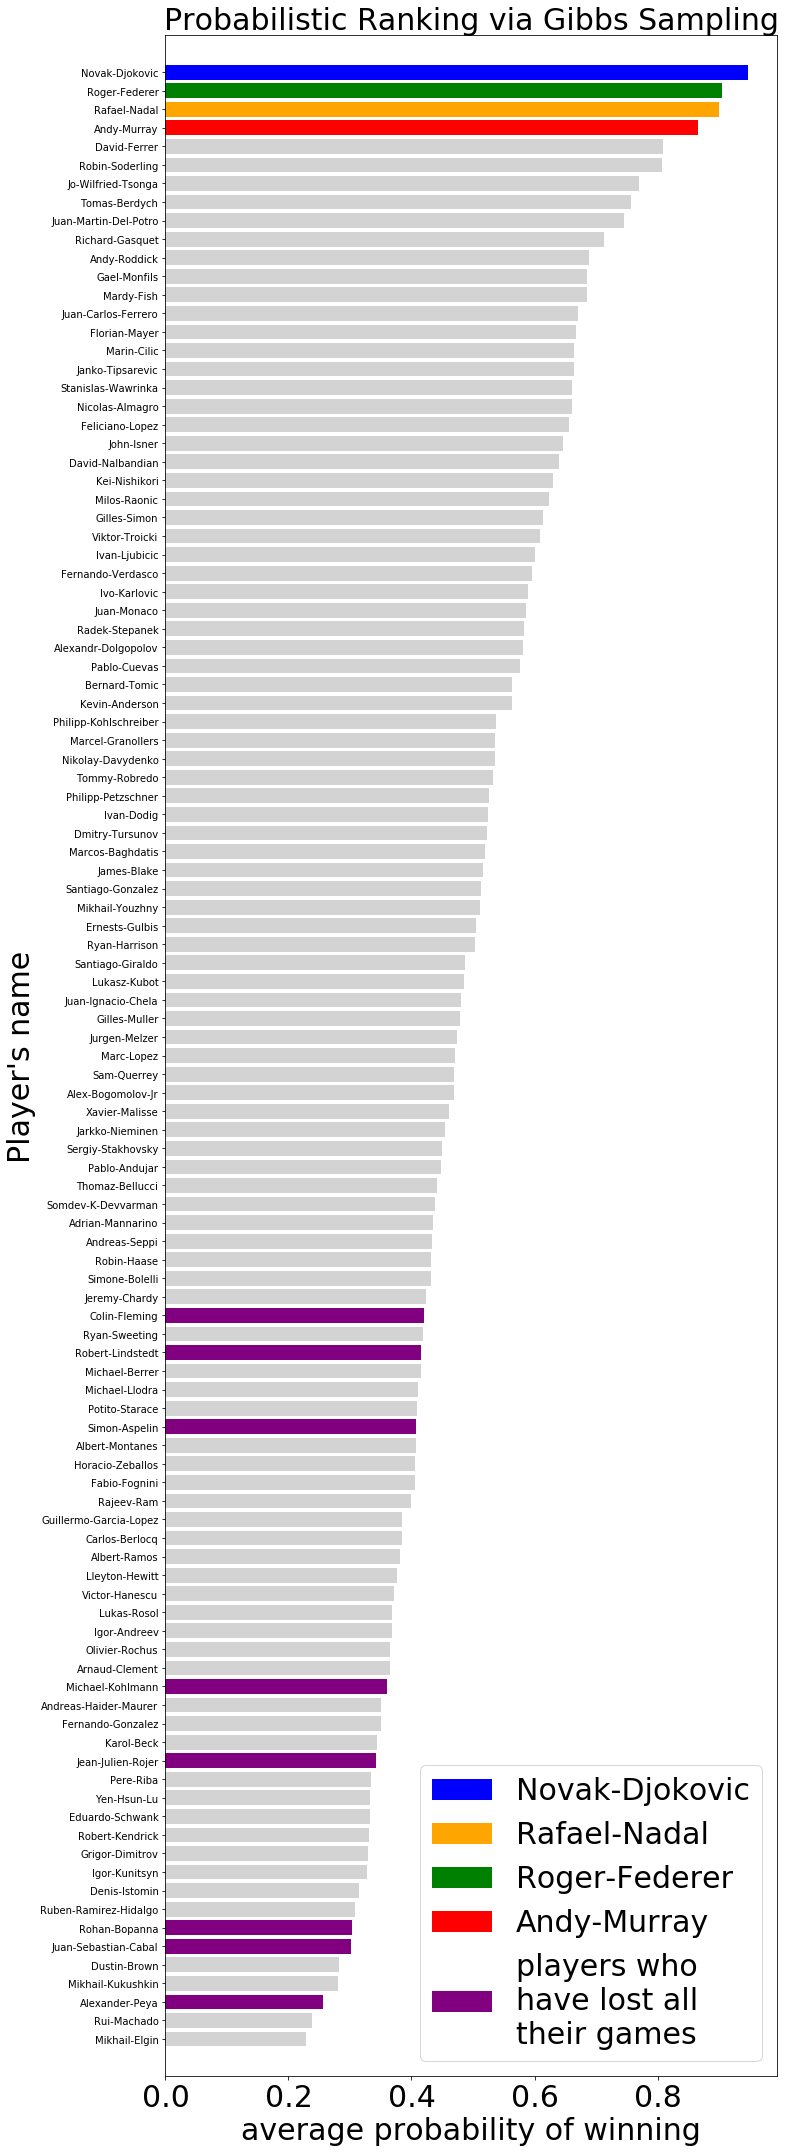

In [6]:
# use marginal skill mean and variance to compute dist of skill difference, hence performance difference.

# For each player, calculate the probability of winning against each of all the 106 other players P(tg >0 | w1,w2),
# then let the average of winning probability be the ranking criterion.

skill_samples = np.load('a_result/skill_samples0(30000iters).npy')

i_thinning = 15
thinned_samples = skill_samples[:,::i_thinning]

noise_var = 1

avg_probs_win = []

for p1 in range(M):
    
    probs_win = []
    
    for p2 in range(M):
        if p2 != p1:
            p1_thinned_samples = thinned_samples[p1,:]
            p2_thinned_samples = thinned_samples[p2,:]

            mean1_apx = np.mean(p1_thinned_samples)
            var1_apx = np.var(p1_thinned_samples)

            mean2_apx = np.mean(p2_thinned_samples)
            var2_apx = np.var(p2_thinned_samples)

            new_mean_Gibbs = mean1_apx - mean2_apx
            new_var_Gibbs = var1_apx + var2_apx + noise_var

            prob_win = 1 - norm.cdf(0, new_mean_Gibbs, np.sqrt(new_var_Gibbs))
            
            probs_win.append(prob_win)
        else:
            probs_win.append(0)
    
    avg_probs_win.append( sum(probs_win)/(M-1) )

avg_probs_win = np.array(avg_probs_win)

sorted_barplot(avg_probs_win, W, ATP_top_players, 'Probabilistic Ranking via Gibbs Sampling', 'lightgrey', empirical_worst_players)
# plt.xlabel('probability that the player wins another player,\n averaged over all 106 possible opponents', fontsize=fontsize)
plt.xlabel('average probability of winning', fontsize=fontsize)

plt.ylabel("Player's name", fontsize=fontsize)
plt.xticks(fontsize=fontsize)

plt.tight_layout()
plt.savefig('e_result/e_Gibbs.jpg')
# plt.savefig('e_result/e_result_Gibbs.jpg')

### e3) predict outcome from *MP skill means and variances*

In [7]:
mean_skills_iters = np.load('b_result/mean_skills_iters.npy')
skill_precisions_iters = np.load('b_result/precisions_iters.npy')

final_mean_skills = mean_skills_iters[:,-1]
final_skill_variances = 1./skill_precisions_iters[:,-1]

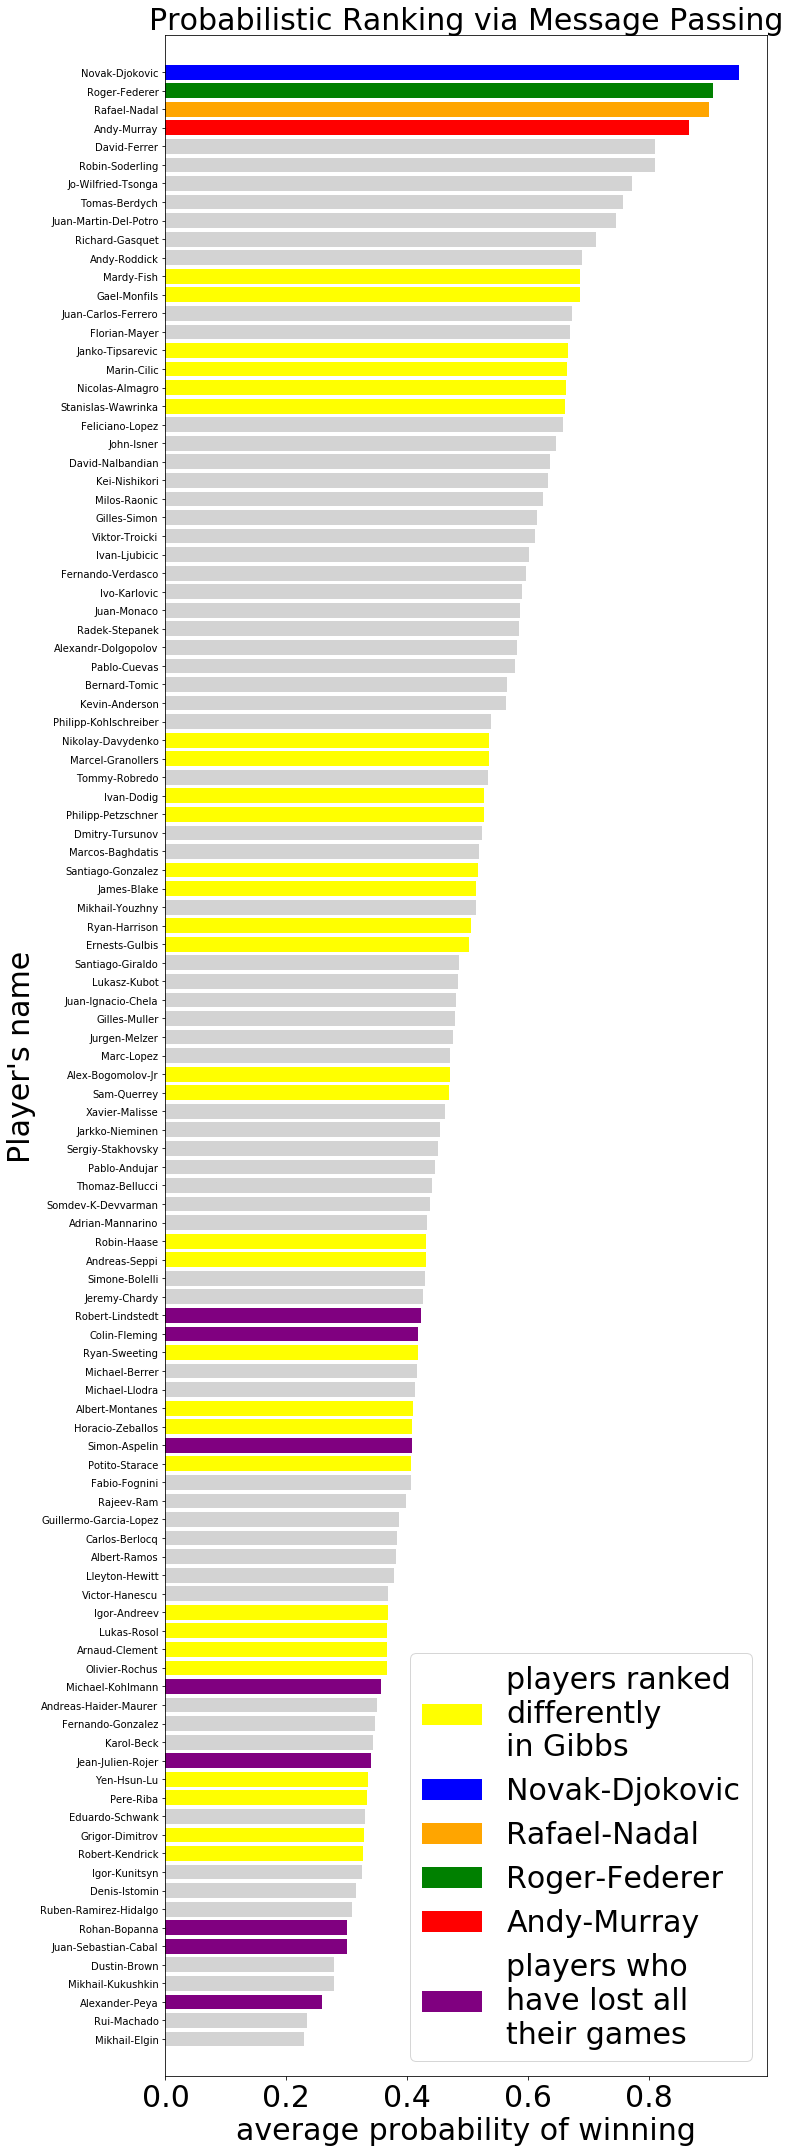

In [8]:
noise_var = 1

avg_probs_win_MP = []

for p1 in range(M):
    
    probs_win = []
    
    mean1 = final_mean_skills[p1]
    var1 = final_skill_variances[p1]
    
    for p2 in range(M):
        if p2 != p1:

            mean2 = final_mean_skills[p2]
            var2 = final_skill_variances[p2]

            new_mean_MP = mean1 - mean2
            new_var_MP = var1 + var2 + noise_var

            prob_win = 1 - norm.cdf(0, new_mean_MP, np.sqrt(new_var_MP))
            
            probs_win.append(prob_win)
        else:
            probs_win.append(0)
    
    avg_probs_win_MP.append( sum(probs_win)/(M-1) )

avg_probs_win_MP = np.array(avg_probs_win_MP)

sorted_barplot(avg_probs_win_MP, W, ATP_top_players, 'Probabilistic Ranking via Message Passing', 'lightgrey',\
               empirical_worst_players, diff=True, P2=avg_probs_win)
# plt.xlabel('probability that the player wins another player,\n averaged over all 106 possible opponents', fontsize=fontsize)
plt.xlabel('average probability of winning', fontsize=fontsize)

plt.ylabel("Player's name", fontsize=fontsize)
plt.xticks(fontsize=fontsize)

plt.tight_layout()
plt.savefig('e_result/e_MP.jpg')
# plt.savefig('e_result/e_result_MP.jpg')

Difference b/w the three ranking systems:

* Empirical: doesn't account for who each player played against, i.e. the skill level of their opponents.

* Gibbs & MP: players with similar ranks in one ranking system can have their ranks shuffled in the other ranking system.
    This indicates that even though both ranking systems are based on marginal distribution of the players' skills, due to how these marginals are derived and the accumulation of their discrepancies, the resulting ranking will be locally different.

If you have time, use black bars to highlight the shuffled players b/w Gibbs and MP rankings.